In [9]:
# Make the width of Jupyter Notebook slightly wider
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

$$
\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}
\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}
$$
# 1. Introduction (hmmm)

Superposition fractal animation from a 1-qubit circuit. \
In order from left: Bloch sphere, fractal animations with one complex numbers, and two variations of Julia set mating. (Indsæt billede?)

Julia set mating enables tying two Julia sets together, thus, making it possible to explicitly include both complex amplitudes of a statevector from a 1-qubit quantum circuit. 

Pasting Julia sets together may happen via the rational function $f(z) = \dfrac{z^2 + c_1}{z^2 + c_2}$, 

with $z = (x + y_i)$ at the point $(x,y)$ in the complex plane, and $c_1$ and $c_2$ representing a state vector’s complex amplitudes. 

An alternate way to represent rational functions is $f(z) = \dfrac{c_1 \cdot z^2 + 1 - c_1}{c_2 \cdot z^2 + 1 - c_2}$.

$\bra{0}, \ket{0}$

## 1.1 Table of Content
[1. Introduction](#1.-Introduction) \
[1.1. Table of Content](#1.1-Table-of-Content) 

[2. Setup](#2.-Setup) \
[2.1. Importing relevant libraries](#2.1-Importing-relevant-libraries)\
[2.2. Defining the Quantum Circuit](#2.2-Defining-the-Quantum-Circuit)\
[2.3. Defining the Fractal calculation parameters](#2.3-Define-the-Fractal-Calculation-parameters)

[3. Computing the Quantum Fractals](#3.-Computing-the-Quantum-Fractals)\
[3.1. Compute Quantum Fractals iteratively with intermediate visualizations](#3.1.-Compute-Quantum-Fractals-iteratively-with-intermediate-visualizations) \
[3.2. Compute all Quantum Fractals, followed by an interactive visualization](#3.2.-Compute-all-Quantum-Fractals,-followed-by-an-interactive-visualization)

[4. Sources](#4.-Sources) \
[4.1 Project-developed modules](#4.1.-Project-developed-modules)

---

# 2. Setup
## 2.1 Importing relevant libraries

In [2]:
# Import standard Python Library to ignore deprecation warning caused by OpenMP implementation in Numba library
import os; os.environ['KMP_WARNINGS'] = 'off' 

# Import externally installed libraries
from qiskit.visualization import plot_bloch_multivector
from ibm_quantum_widgets import CircuitComposer
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from tqdm import tqdm

# Import project-modules
from utils.fractal_julia_calculations import set_1cn0, set_2cn1, set_2cn2
from utils.fractal_julia_generalized import set_general, get_fraction_powers_and_indices
from utils.fractal_quantum_circuit import FractalQuantumCircuit
from utils.fractal_visualization import QuantumFractalVisualization
from utils.fractal_julia_arrays import GetJuliaArrays

## 2.2 Defining the Quantum Circuit
The calculations in this notebook only supports 1-qubit Quantum Circuits, hence why the default setup only uses a single Qubit. 

However, the initial starting point on the Bloch Sphere, the superposition state, can be changed at will and is not a requirement for running the later computations of the Julia Sets for the Quantum Circuit.

For changing the initial gate(s) to define the intial starting point for the Qubit, you can either:
1. Change the Quantum Circuit in the code cell below or
2. Drag different gates into The Circuit Composer Widget

But before doing so, please note three things:
1. The initially provided Quantum Circuit __yields the 1-qubit fractals as seen at the start of the notebook. (Indsæt billede(r)?)__
2. The best fractal results are achieved when the resulting circuit is not on the Bloch sphere’s diagonals.
3. You may need to experiment with different gates, phases and circuits in order to produce a circuit that generates an interesting fractal. <br><br>

In [8]:
# Create the Quantum Circuit either by coding it or by using the CircuitComposer
circuit = QuantumCircuit(1)
circuit.h(0)

# Method to save Open the CircuitComposer
editor = CircuitComposer(circuit=circuit); display(editor)

CircuitComposer(circuit=<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x11ca89c90>)

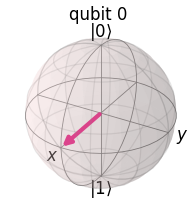

In [4]:
# In case this cell is run again, reset the PyPlot (plt) values to avoid over-sized Bloch Sphere
plt.rcParams["figure.figsize"] = (1,1)
plt.rcParams['figure.dpi'] = 60

# Visualize the Bloch sphere(s) based on the Quantum Circuit defined above.
plot_bloch_multivector(editor.circuit)

## 2.3 Define the Fractal Calculation parameters

In [10]:
# Define coordinate height, width and size values for the resulting Julia image arrays
# ──────────────────────────────────────────────────────────────────────────────────────────────────────────
# Image generation and animation values
GIF_ms_intervals: int = 200  # 200ms = 5 fps
number_of_frames: int = 30  # Total number of frames to generate

# Coordinate height, width and zoom
height: int = 200
width: int  = 200
zoom: float = 1.0

# Coordinate intervals
x_start: float = 0.0
x_width: float = 1.5

y_start: float = 0.0
y_width: float = 1.5


# Define the number of iterations before the magnitude of z exceeds the defined escape value
# ──────────────────────────────────────────────────────────────────────────────────────────────────────────
julia_iterations: int = 100
julia_escape_val: int = 2


# Create the basis 2D array for the fractal
# ──────────────────────────────────────────────────────────────────────────────────────────────────────────
get_julia_arrays = GetJuliaArrays(julia_iterations, x_start, x_width, y_start, y_width, height, width, zoom)

# Array with the evenly spaced numbers over the width- and height interval specified above
z_arr = get_julia_arrays.get_z_array()

# Array to keep track of which iteration that causes the points to diverge
div_arr = get_julia_arrays.get_diverged_array()

# Array to keep track of which points have not converged for each iteration
con_arr = get_julia_arrays.get_converging_array()

---
# 3. Computing the Quantum Fractals
After defining the coordinate- and visualization-specific variables in the section above, it is time to run the Julia Set calculations and visualize their results.

For doing so, there are two options.

__[3.1](#3.1.-Compute-Quantum-Fractals-iteratively-with-intermediate-visualizations)__) Run the calculations _iteratively_, followed by a gif animation. This code cell will present the resulting visualizations for each frame of the calculation. Afterward, the resulting image will combine all the visualizations generated in a final animated gif.

__[3.2](#3.2.-Run-the-calculations-in-advance,-followed-by-an-interactive-visualization)__) Run the calculations _in advance_ as an interactive visualization. This code cell, contrary to 3.1, will calculate all frames before showing it to you. However, when the calculation has been completed, you are shown all the frames in an interactive window. You can go through the images one by one or let the interactive animation loop through all the images as if it were an animated gif.

## 3.1. Compute Quantum Fractals iteratively with intermediate visualizations
__1. While running__, a visual output will be shown for each calculation of a frame\
__2. In the end__, all images during computing will be combined and shown as an animated GIF 


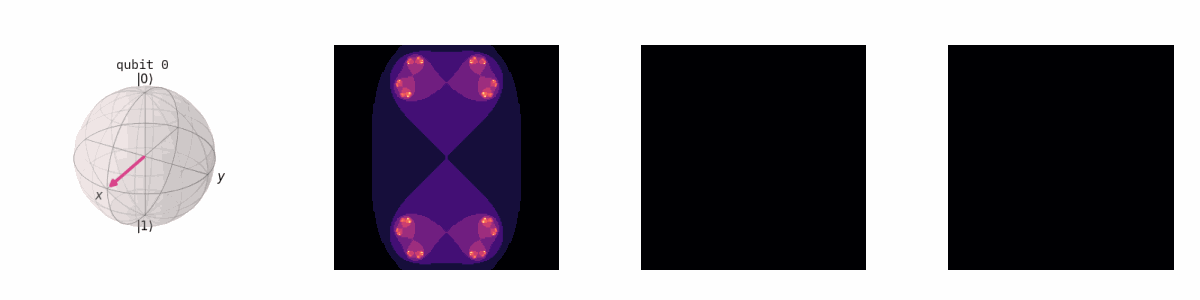

In [11]:
# Initiate the two classes responsible for generating the Bloch's sphere and visualiaztions
fractal_circuit = FractalQuantumCircuit(quantum_circuit=editor.circuit, total_number_of_frames=number_of_frames)
fractal_visuals = QuantumFractalVisualization()

for frame in tqdm(range(0, number_of_frames)):
    # Perform a Latitudinal Rotation on the Qubit as visualized on the Bloch's sphere
    cno, ccircuit, ccn = fractal_circuit.get_quantum_circuit(frame_iteration=frame)

    # Perform the Julia Set Calculations for the state of the Bloch's sphere
    julia1 = set_1cn0(c=cno, z=z_arr.copy(), con=con_arr.copy(), div=div_arr.copy(), height=height, width=width)
    julia2 = set_2cn1(c=ccn, z=z_arr.copy(), con=con_arr.copy(), div=div_arr.copy(), height=height, width=width)
    julia3 = set_2cn2(c=ccn, z=z_arr.copy(), con=con_arr.copy(), div=div_arr.copy(), height=height, width=width)
    
    # Save both the Quantum circuit and Julia Calculation results in a visualisation list
    visualization_data = [ccircuit, julia1, julia2, julia3]

    # Parse the visualization data to both the image and animation generators
    fractal_visuals.qf_images(viz_data=visualization_data, frame=frame)
    fractal_visuals.qf_gif_animation(viz_data=visualization_data, frame=frame)

# Finally, after having iterted through all the franes, the final GIF is created and shown
fractal_visuals.save_gif_animation(blit=True, interval_ms=GIF_ms_intervals, no_frames=number_of_frames)

## 3.2. Compute all Quantum Fractals, followed by an interactive visualization
__1. While running__, nothing will be shown \
__2. In the end__, an interactive display will be shown, where you can choose to go through all the frames image by image or run it as a loop, similar to a GIF.

In [12]:
fractal_visuals.qf_interactive_animation(
    quantum_circuit=editor.circuit,
    frame_no=number_of_frames,
    z_arr = z_arr,
    div_arr = div_arr,
    con_arr = con_arr,
    height=height,
    width=width,
    interval=GIF_ms_intervals
)

---
# 4. Sources

## 4.1. Project-developed modules
[fractal_julia_calculations](/edit/quantum_fractals_guidebook/utils/fractal_julia_calculations.py) - High performance Numba functions to speed up the Julia Set calculations. \
[fractal_quantum_circuit](/edit/quantum_fractals_guidebook/utils/fractal_quantum_circuit.py) - Class to either initiate or receive a Quantum Circuit and methods to perform latitudinal rotations \
[fractal_visualization](/edit/quantum_fractals_guidebook/utils/fractal_visualization.py) - Class to visualize the Julia Set results as either (1) an still image, (2) an animated GIF over time and/or (3) create an interactive plot\
[fractal_julia_arrays](/edit/quantum_fractals_guidebook/utils/fractal_julia_arrays.py) - Class to create the arrays needed when performing the Julia Set calculations